In [64]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# ppi results
PPI_ACT_PATH = './ppiMatrices'
PPI_SCH_PATH = './ppiMatricesSchaefer'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


In [171]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from scipy.stats import ttest_1samp
from statsmodels.stats.proportion import binom_test

import notebook_functions as nf

In [116]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/PPITest/notebook_functions.py'>

## load the bold qa measures

In [13]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [14]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [15]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [16]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Get the correlation files

In [65]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
ppi_sch_layout = BIDSLayout(PPI_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])
ppi_act_layout = BIDSLayout(PPI_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [18]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [155]:
# activation atlas
ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['switchxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_act_ppi_objs = nf.get_layout_objects(ppi_act_layout,
                                       ['switchxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)


# schaefer atlas
ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['switchxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="taskswitch",
                                       subject=good_participants)

fb_sch_ppi_objs = nf.get_layout_objects(ppi_sch_layout,
                                       ['switchxsingle', 'repeatxsingle', 'switchxrepeat'],
                                       suffix="matrix", extension="tsv",
                                       task="fauxbold",
                                       subject=good_participants)

In [156]:
# ppi activation
ts_act_ppi_switchxrepeat = nf.bind_matrices(ts_act_ppi_objs['switchxrepeat'], "ppi")
fb_act_ppi_switchxrepeat = nf.bind_matrices(fb_act_ppi_objs['switchxrepeat'], "ppi")
ts_act_ppi_switchxsingle = nf.bind_matrices(ts_act_ppi_objs['switchxsingle'], "ppi")
fb_act_ppi_switchxsingle = nf.bind_matrices(fb_act_ppi_objs['switchxsingle'], "ppi")
ts_act_ppi_repeatxsingle = nf.bind_matrices(ts_act_ppi_objs['repeatxsingle'], "ppi")
fb_act_ppi_repeatxsingle = nf.bind_matrices(fb_act_ppi_objs['repeatxsingle'], "ppi")

# ppi schaefer
ts_sch_ppi_switchxrepeat = nf.bind_matrices(ts_sch_ppi_objs['switchxrepeat'], "ppi")
fb_sch_ppi_switchxrepeat = nf.bind_matrices(fb_sch_ppi_objs['switchxrepeat'], "ppi")
ts_sch_ppi_switchxsingle = nf.bind_matrices(ts_sch_ppi_objs['switchxsingle'], "ppi")
fb_sch_ppi_switchxsingle = nf.bind_matrices(fb_sch_ppi_objs['switchxsingle'], "ppi")
ts_sch_ppi_repeatxsingle = nf.bind_matrices(ts_sch_ppi_objs['repeatxsingle'], "ppi")
fb_sch_ppi_repeatxsingle = nf.bind_matrices(fb_sch_ppi_objs['repeatxsingle'], "ppi")


# lss activation
ts_act_lss_switchxrepeat = nf.bind_matrices(ts_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lss_switchxrepeat = nf.bind_matrices(fb_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lss_switchxsingle = nf.bind_matrices(ts_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]
fb_act_lss_switchxsingle = nf.bind_matrices(fb_act_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]

ts_act_lss_repeatxsingle = nf.bind_matrices(ts_act_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lss_objs['single'], "single").iloc[:,:-2]
ts_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lss_repeatxsingle = nf.bind_matrices(fb_act_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lss_objs['single'], "single").iloc[:,:-2]
fb_act_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lss schaefer
ts_sch_lss_switchxrepeat = nf.bind_matrices(ts_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lss_switchxrepeat = nf.bind_matrices(fb_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lss_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lss_switchxsingle = nf.bind_matrices(ts_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]
fb_sch_lss_switchxsingle = nf.bind_matrices(fb_sch_lss_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]

ts_sch_lss_repeatxsingle = nf.bind_matrices(ts_sch_lss_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lss_objs['single'], "single").iloc[:,:-2]
ts_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lss_repeatxsingle = nf.bind_matrices(fb_sch_lss_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lss_objs['single'], "single").iloc[:,:-2]
fb_sch_lss_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa activation
ts_act_lsa_switchxrepeat = nf.bind_matrices(ts_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]
fb_act_lsa_switchxrepeat = nf.bind_matrices(fb_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_act_lsa_switchxrepeat[['participant_id', 'task']] = ts_act_ppi_switchxrepeat[['participant_id', 'task']]

ts_act_lsa_switchxsingle = nf.bind_matrices(ts_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]
fb_act_lsa_switchxsingle = nf.bind_matrices(fb_act_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_switchxsingle[['participant_id', 'task']] = ts_act_ppi_switchxsingle[['participant_id', 'task']]

ts_act_lsa_repeatxsingle = nf.bind_matrices(ts_act_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_act_lsa_objs['single'], "single").iloc[:,:-2]
ts_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]
fb_act_lsa_repeatxsingle = nf.bind_matrices(fb_act_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_act_lsa_objs['single'], "single").iloc[:,:-2]
fb_act_lsa_repeatxsingle[['participant_id', 'task']] = ts_act_ppi_repeatxsingle[['participant_id', 'task']]

# lsa schaefer
ts_sch_lsa_switchxrepeat = nf.bind_matrices(ts_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
ts_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]
fb_sch_lsa_switchxrepeat = nf.bind_matrices(fb_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2]
fb_sch_lsa_switchxrepeat[['participant_id', 'task']] = ts_sch_ppi_switchxrepeat[['participant_id', 'task']]

ts_sch_lsa_switchxsingle = nf.bind_matrices(ts_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_switchxsingle[['participant_id', 'task']] = ts_sch_ppi_switchxsingle[['participant_id', 'task']]
fb_sch_lsa_switchxsingle = nf.bind_matrices(fb_sch_lsa_objs['switch'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_switchxsingle[['participant_id', 'task']] = ts_sch_ppi_switchxsingle[['participant_id', 'task']]

ts_sch_lsa_repeatxsingle = nf.bind_matrices(ts_sch_lsa_objs['repeat'], "repeat").iloc[:,:-2] - nf.bind_matrices(ts_sch_lsa_objs['single'], "single").iloc[:,:-2]
ts_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]
fb_sch_lsa_repeatxsingle = nf.bind_matrices(fb_sch_lsa_objs['repeat'], "switch").iloc[:,:-2] - nf.bind_matrices(fb_sch_lsa_objs['single'], "single").iloc[:,:-2]
fb_sch_lsa_repeatxsingle[['participant_id', 'task']] = ts_sch_ppi_repeatxsingle[['participant_id', 'task']]

In [79]:
np.corrcoef(ts_sch_ppi_repeatxsingle.mean(axis=0).values, ts_sch_lss_repeatxsingle.mean(axis=0).values)

array([[1.        , 0.61467669],
       [0.61467669, 1.        ]])

In [56]:
ts_act_lsa_repeatxsingle_mean = ts_act_lsa_repeatxsingle.mean(axis=0).values
ts_act_lss_repeatxsingle_mean = ts_act_lss_repeatxsingle.mean(axis=0).values
ts_act_ppi_repeatxsingle_mean = ts_act_ppi_repeatxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_repeatxsingle_mean, ts_act_lss_repeatxsingle_mean, ts_act_ppi_repeatxsingle_mean])

array([[1.        , 0.28734264, 0.19827265],
       [0.28734264, 1.        , 0.56697634],
       [0.19827265, 0.56697634, 1.        ]])

In [57]:
ts_act_lsa_switchxrepeat_mean = ts_act_lsa_switchxrepeat.mean(axis=0).values
ts_act_lss_switchxrepeat_mean = ts_act_lss_switchxrepeat.mean(axis=0).values
ts_act_ppi_switchxrepeat_mean = ts_act_ppi_switchxrepeat.mean(axis=0).values
np.corrcoef([ts_act_lsa_switchxrepeat_mean, ts_act_lss_switchxrepeat_mean, ts_act_ppi_switchxrepeat_mean])

array([[1.        , 0.30559026, 0.23456179],
       [0.30559026, 1.        , 0.45726016],
       [0.23456179, 0.45726016, 1.        ]])

In [60]:
ts_act_lsa_switchxsingle_mean = ts_act_lsa_switchxsingle.mean(axis=0).values
ts_act_lss_switchxsingle_mean = ts_act_lss_switchxsingle.mean(axis=0).values
ts_act_ppi_switchxsingle_mean = ts_act_ppi_switchxsingle.mean(axis=0).values
np.corrcoef([ts_act_lsa_switchxsingle_mean, ts_act_lss_switchxsingle_mean, ts_act_ppi_switchxsingle_mean])

array([[1.        , 0.37228506, 0.24149893],
       [0.37228506, 1.        , 0.61454584],
       [0.24149893, 0.61454584, 1.        ]])

## Activation Atlas: Switch - Single (Real Data)

Number of Positives lsa: 11 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 3 / 210
Number of Positives lss: 10 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 7 / 210


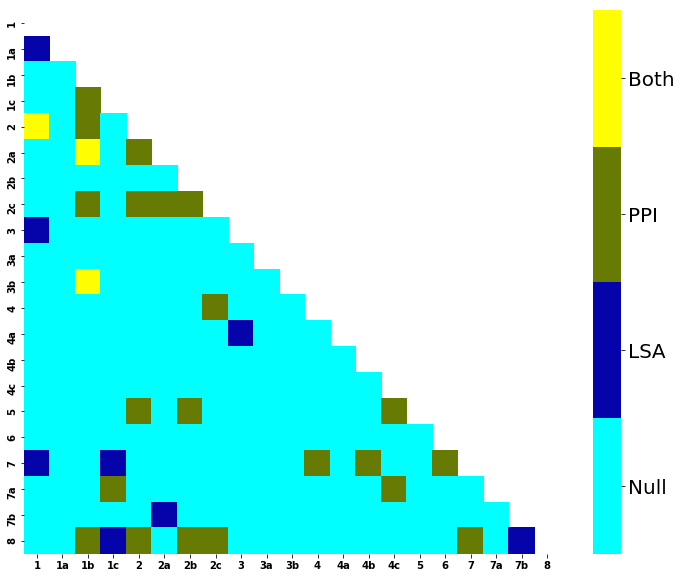

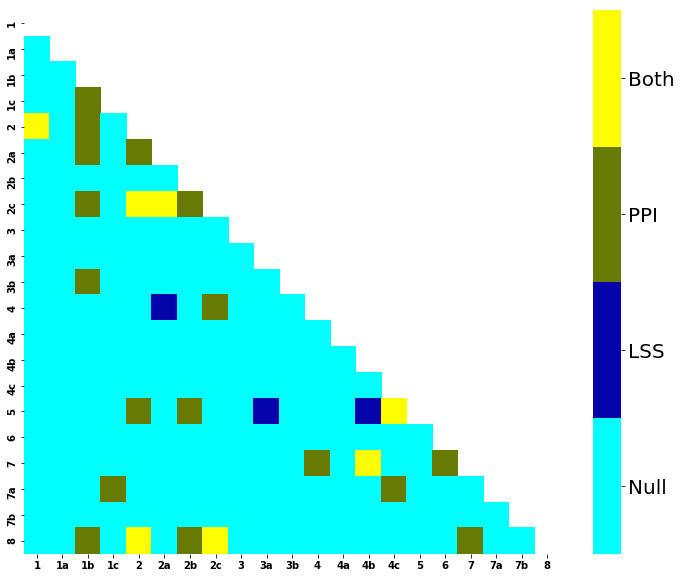

In [143]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_switchxsingle, ts_act_lss_switchxsingle, ts_act_lsa_switchxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [144]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.35567833, 0.25617891],
       [0.35567833, 1.        , 0.60719371],
       [0.25617891, 0.60719371, 1.        ]])

## Activation Atlas: Switch - Single (Null Data)

Number of Positives lsa: 12 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 5 / 210
Number of Positives lss: 13 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 7 / 210


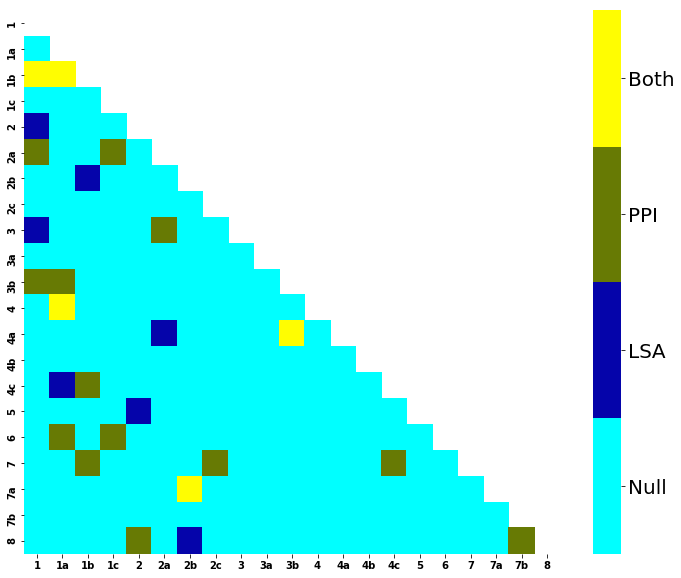

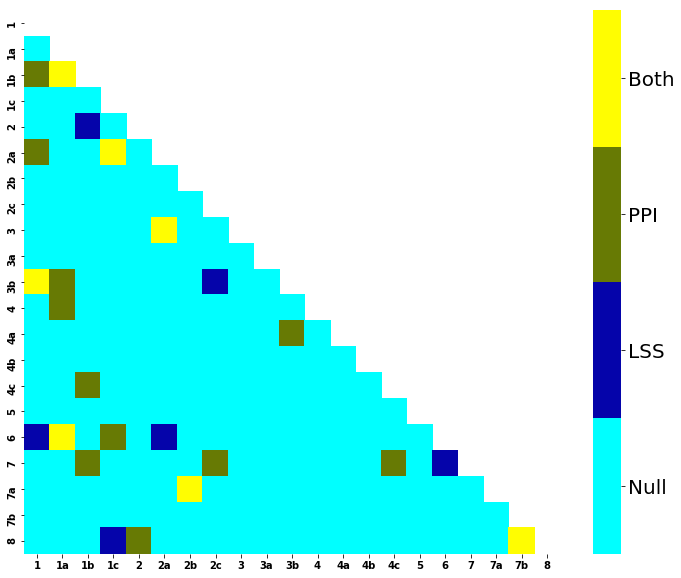

In [145]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_switchxsingle, fb_act_lss_switchxsingle, fb_act_lsa_switchxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [146]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.38959677, 0.39218562],
       [0.38959677, 1.        , 0.66119308],
       [0.39218562, 0.66119308, 1.        ]])

## Activation Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 21 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210
Number of Positives lss: 16 / 210
Number of Positives ppi: 25 / 210
Number of overlapping positives: 4 / 210


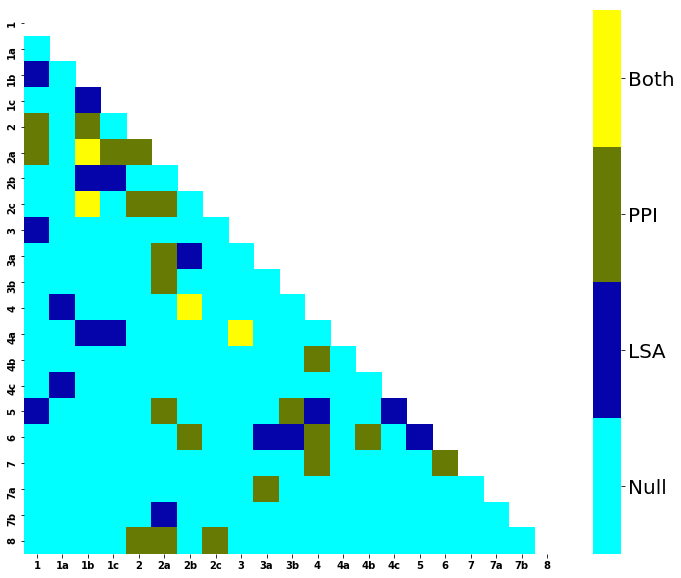

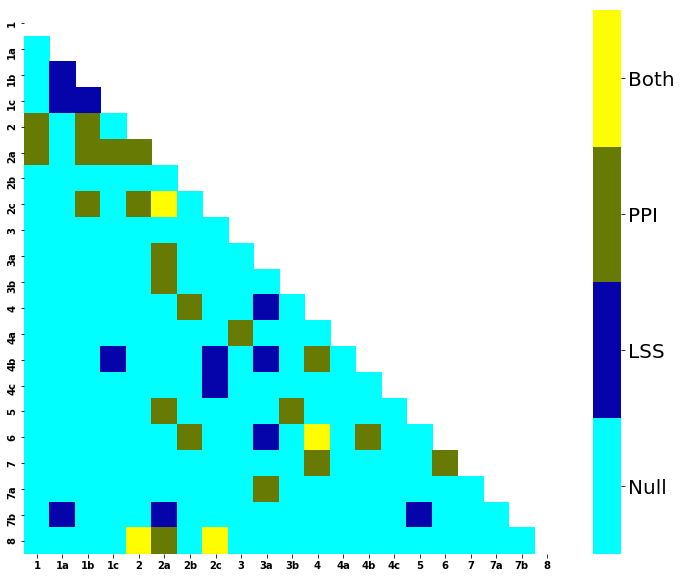

In [147]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_repeatxsingle, ts_act_lss_repeatxsingle, ts_act_lsa_repeatxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [148]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.31260691, 0.22934983],
       [0.31260691, 1.        , 0.56167524],
       [0.22934983, 0.56167524, 1.        ]])

## Activation Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 10 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 12 / 210
Number of Positives ppi: 24 / 210
Number of overlapping positives: 5 / 210


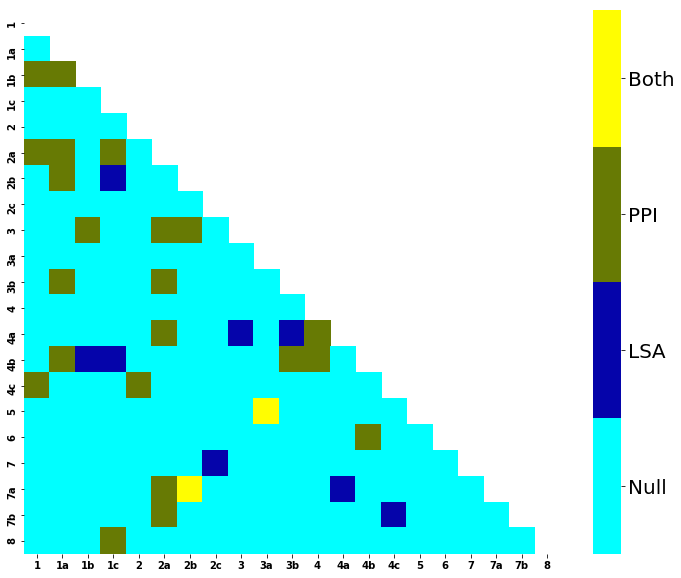

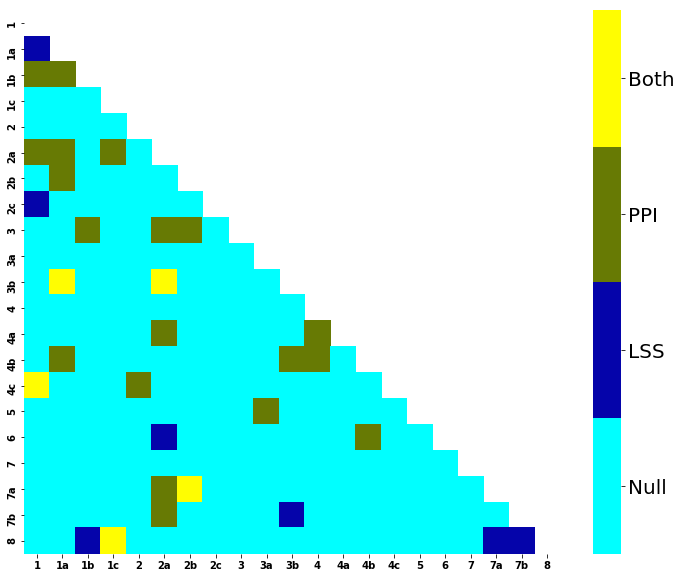

In [149]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_repeatxsingle, fb_act_lss_repeatxsingle, fb_act_lsa_repeatxsingle,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [150]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.440006  , 0.39759459],
       [0.440006  , 1.        , 0.69317566],
       [0.39759459, 0.69317566, 1.        ]])

## Activation Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 15 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 2 / 210
Number of Positives lss: 6 / 210
Number of Positives ppi: 18 / 210
Number of overlapping positives: 1 / 210


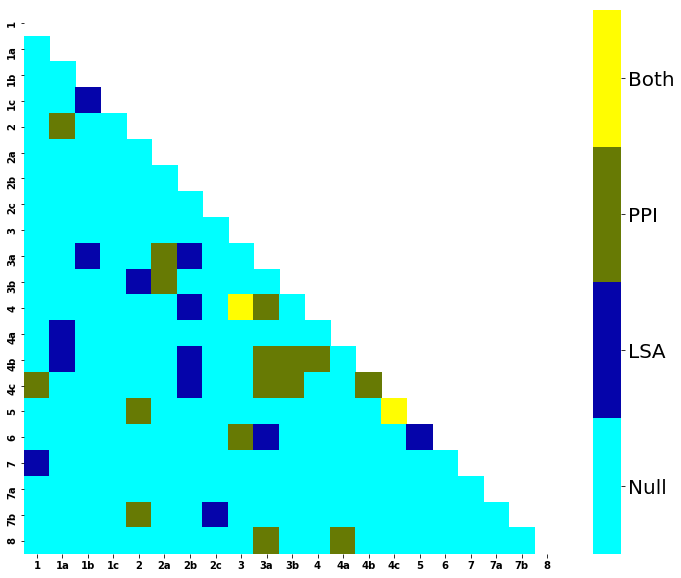

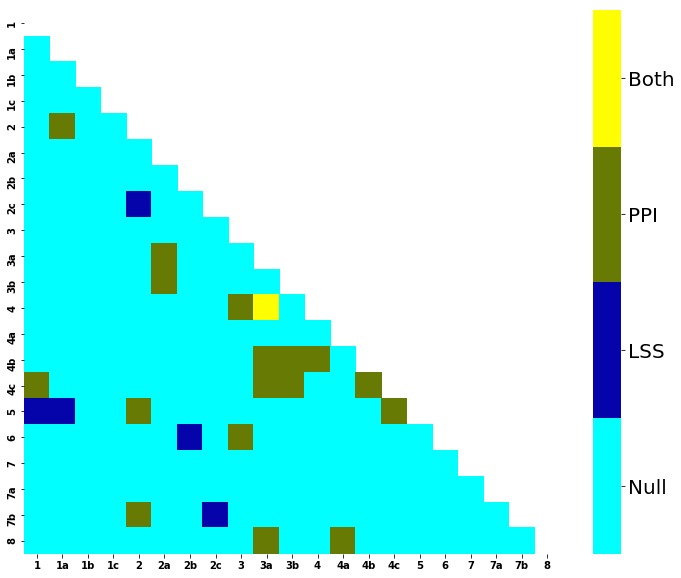

In [151]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_act_ppi_switchxrepeat, ts_act_lss_switchxrepeat, ts_act_lsa_switchxrepeat,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [152]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.29343153, 0.22671906],
       [0.29343153, 1.        , 0.47083959],
       [0.22671906, 0.47083959, 1.        ]])

## Activation Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 12 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210
Number of Positives lss: 3 / 210
Number of Positives ppi: 13 / 210
Number of overlapping positives: 1 / 210


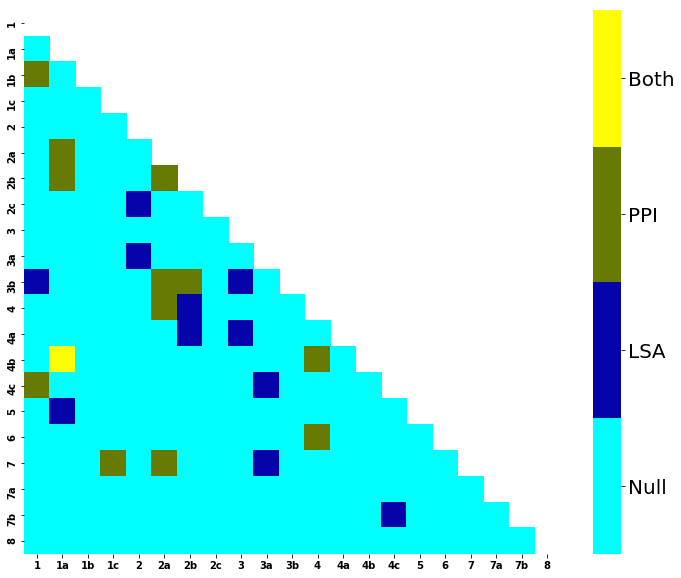

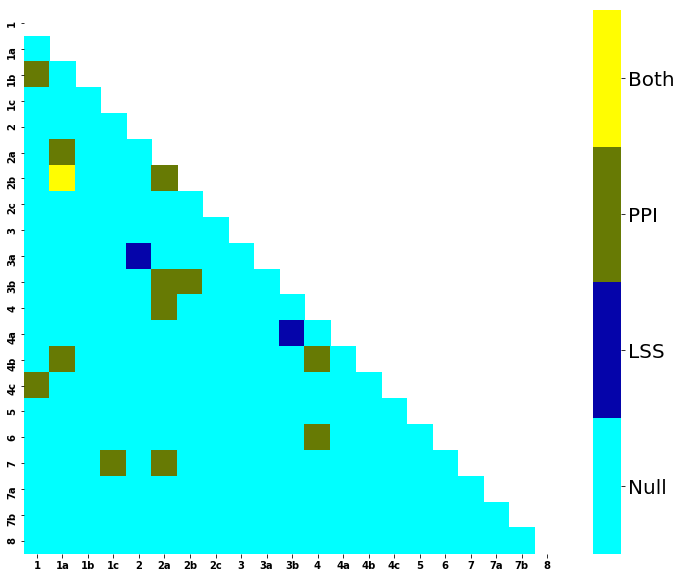

In [153]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_act_ppi_switchxrepeat, fb_act_lss_switchxrepeat, fb_act_lsa_switchxrepeat,
    rois="activation", nthreads=N_THREADS, use_python=True)

In [154]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.24442152, 0.25035555],
       [0.24442152, 1.        , 0.43974041],
       [0.25035555, 0.43974041, 1.        ]])

## Schaefer Analysis Prep

In [165]:
import pickle
with open('../nibsAnalysis/outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions

['ContA-LH_IPS_1',
 'VisCent-RH_ExStr_5',
 'VisCent-RH_ExStr_4',
 'Limbic-LH_TempPole_7',
 'Limbic-RH_TempPole_5',
 'VisCent-LH_ExStr_7',
 'DefaultA-LH_PCC_6',
 'Limbic-RH_OFC_5',
 'Limbic-LH_TempPole_2',
 'VisCent-RH_ExStr_2',
 'VisCent-RH_ExStr_7',
 'VisCent-LH_ExStr_3',
 'Limbic-RH_OFC_3',
 'VisCent-RH_ExStr_6',
 'VisCent-LH_ExStr_4',
 'Limbic-LH_OFC_3',
 'VisCent-RH_ExStr_9',
 'VisCent-LH_ExStr_5',
 'DefaultC-LH_PHC_1',
 'VisPeri-LH_ExStrSup_6']

## Schaefer Atlas: Switch - Single (Real Data)

Number of Positives lsa: 6363 / 79800
Number of Positives ppi: 9335 / 79800
Number of overlapping positives: 1240 / 79800
Number of Positives lss: 6625 / 79800
Number of Positives ppi: 9335 / 79800
Number of overlapping positives: 2162 / 79800


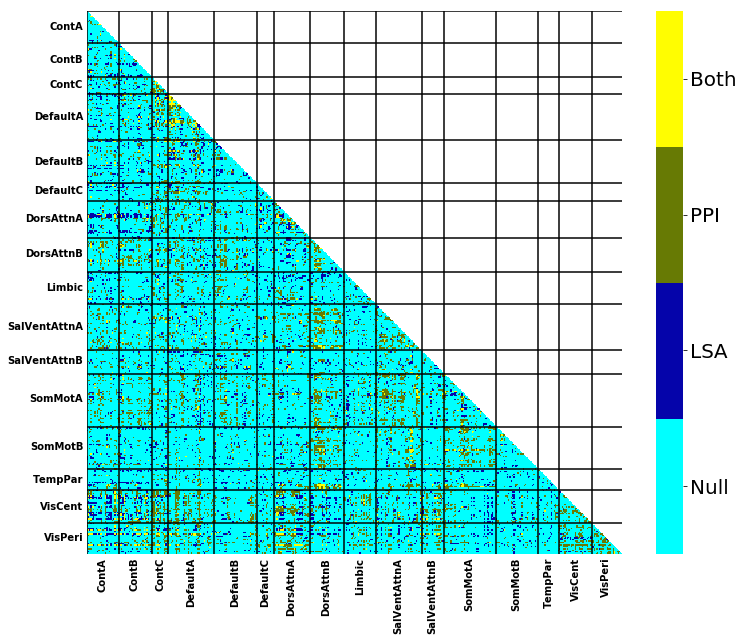

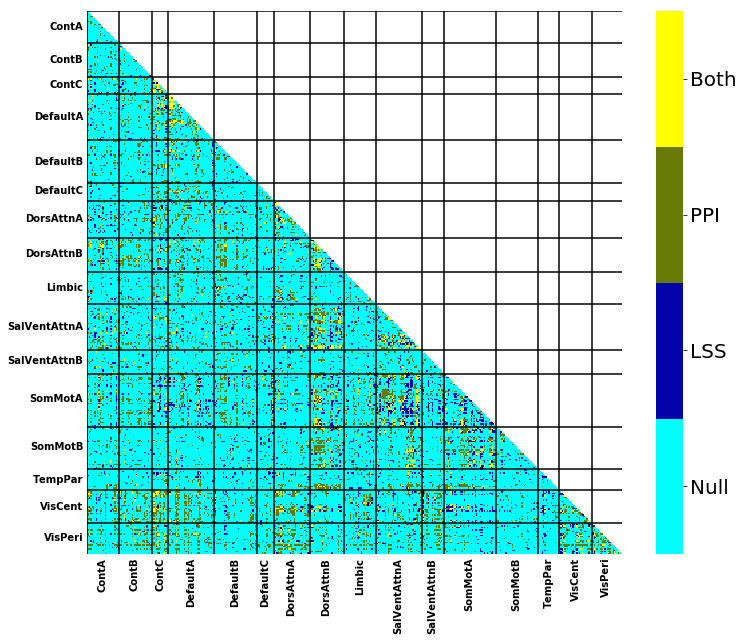

In [173]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_switchxsingle, ts_sch_lss_switchxsingle, ts_sch_lsa_switchxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [174]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.36342078, 0.25156815],
       [0.36342078, 1.        , 0.48222473],
       [0.25156815, 0.48222473, 1.        ]])

In [175]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

32
1.8602672759998237e-09


## Schaefer Atlas: Switch - Single (Null Data)

Number of Positives lsa: 4610 / 79800
Number of Positives ppi: 4014 / 79800
Number of overlapping positives: 216 / 79800
Number of Positives lss: 5101 / 79800
Number of Positives ppi: 4014 / 79800
Number of overlapping positives: 252 / 79800


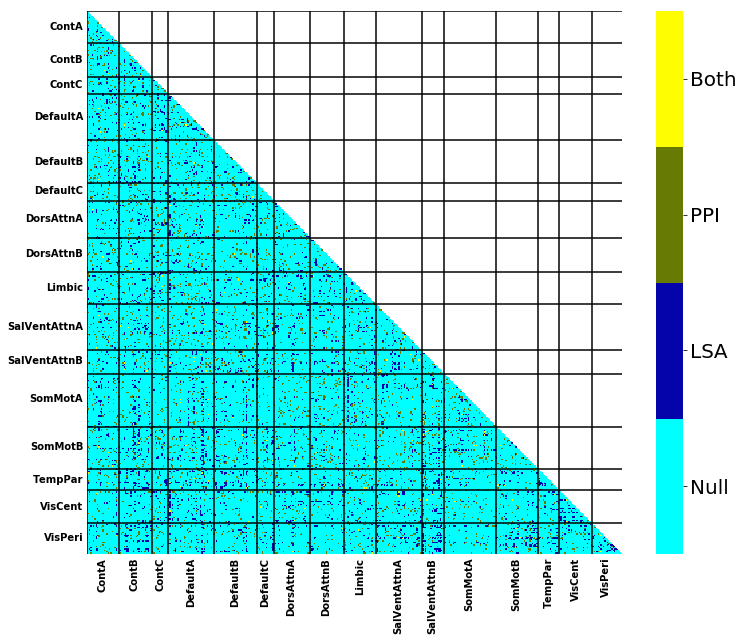

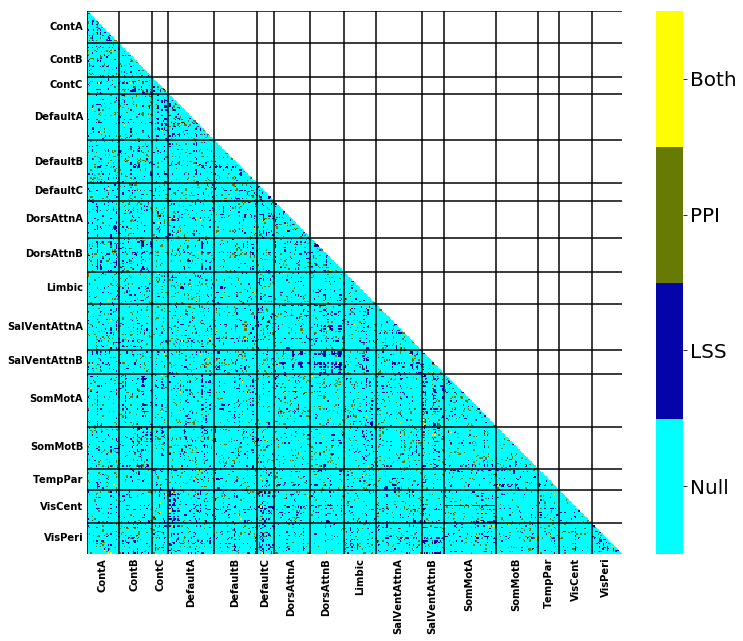

In [182]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_switchxsingle, fb_sch_lss_switchxsingle, fb_sch_lsa_switchxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [183]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.00000000e+00, 4.15581393e-01, 7.60738508e-04],
       [4.15581393e-01, 1.00000000e+00, 3.72806445e-03],
       [7.60738508e-04, 3.72806445e-03, 1.00000000e+00]])

In [184]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

12
0.24383702466153648


## Schaefer Atlas: Repeat - Single (Real Data)

Number of Positives lsa: 9145 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 2140 / 79800
Number of Positives lss: 7631 / 79800
Number of Positives ppi: 12895 / 79800
Number of overlapping positives: 3773 / 79800


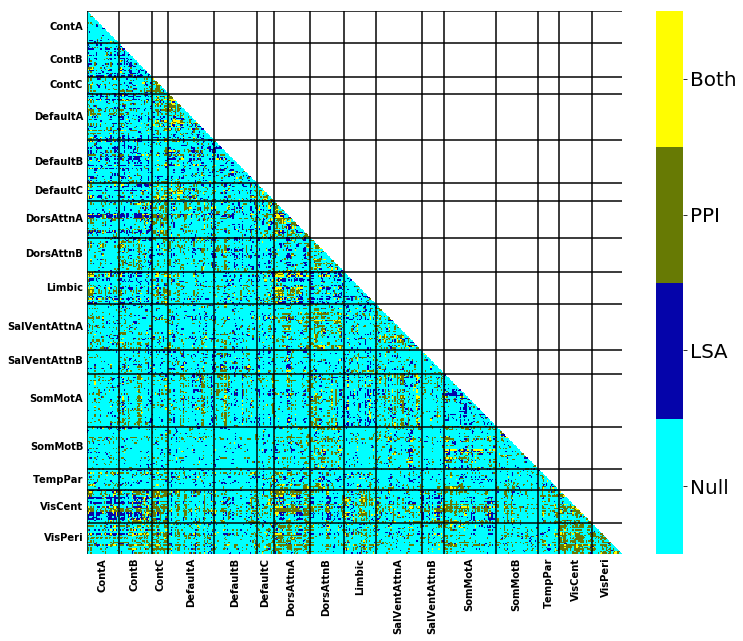

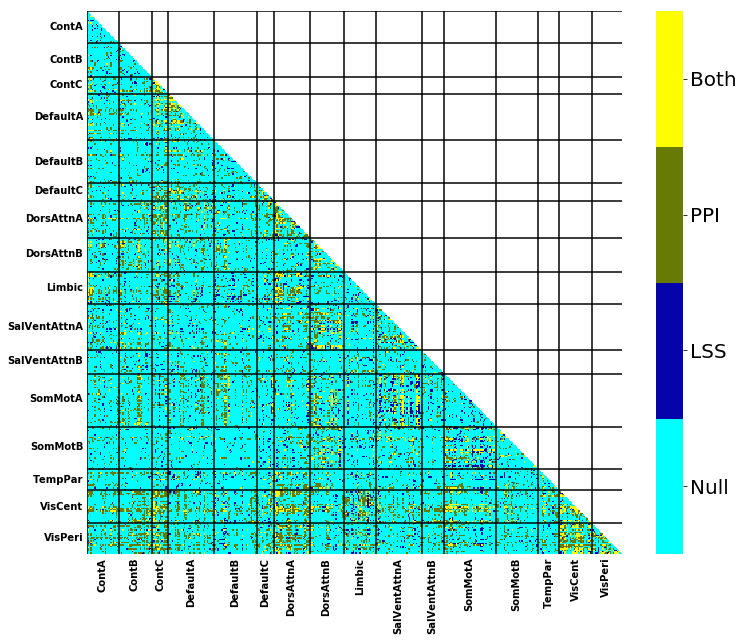

In [176]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_repeatxsingle, ts_sch_lss_repeatxsingle, ts_sch_lsa_repeatxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [177]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.36220345, 0.2700873 ],
       [0.36220345, 1.        , 0.61879456],
       [0.2700873 , 0.61879456, 1.        ]])

In [178]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

59
1.9487897167786183e-30


## Schaefer Atlas: Repeat - Single (Null Data)

Number of Positives lsa: 6762 / 79800
Number of Positives ppi: 3835 / 79800
Number of overlapping positives: 306 / 79800
Number of Positives lss: 8461 / 79800
Number of Positives ppi: 3835 / 79800
Number of overlapping positives: 431 / 79800


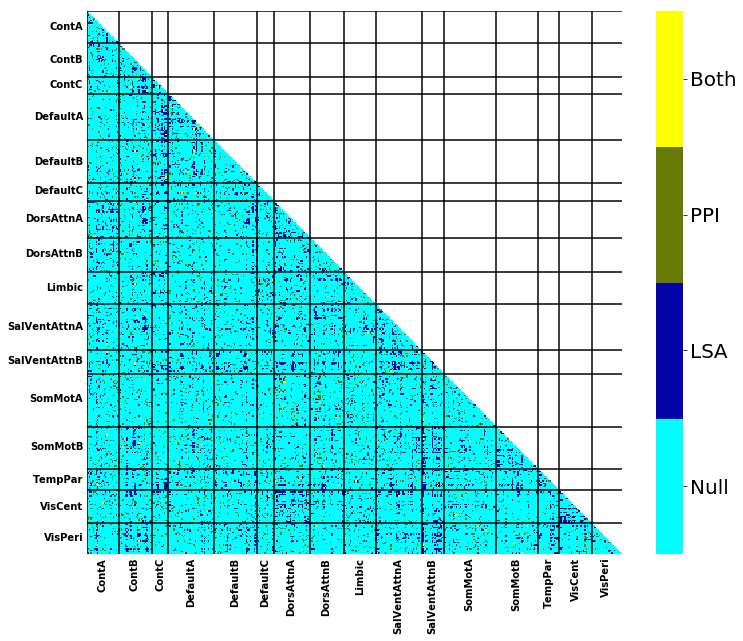

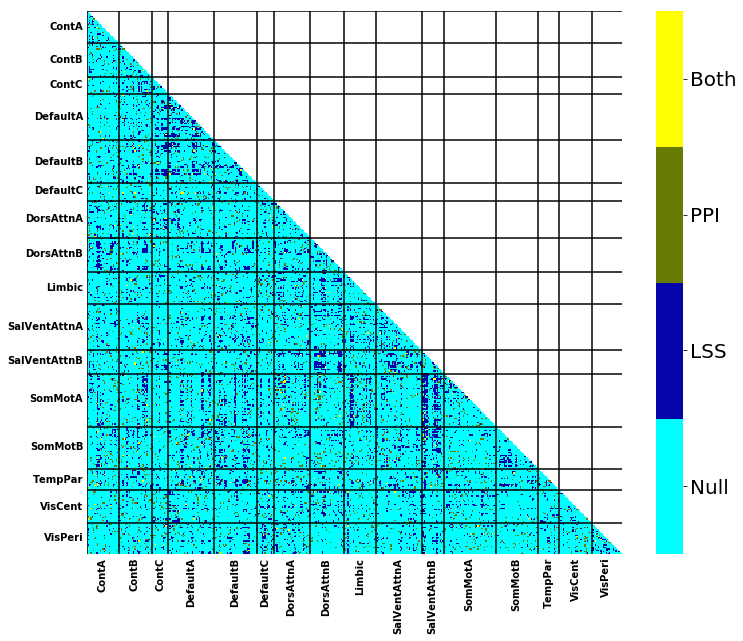

In [185]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_repeatxsingle, fb_sch_lss_repeatxsingle, fb_sch_lsa_repeatxsingle,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [186]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[ 1.        ,  0.46921821, -0.00188941],
       [ 0.46921821,  1.        ,  0.00138873],
       [-0.00188941,  0.00138873,  1.        ]])

In [187]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

18
0.007332862963713873


## Schaefer Atlas: Switch - Repeat (Real Data)

Number of Positives lsa: 5153 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 388 / 79800
Number of Positives lss: 3462 / 79800
Number of Positives ppi: 3947 / 79800
Number of overlapping positives: 406 / 79800


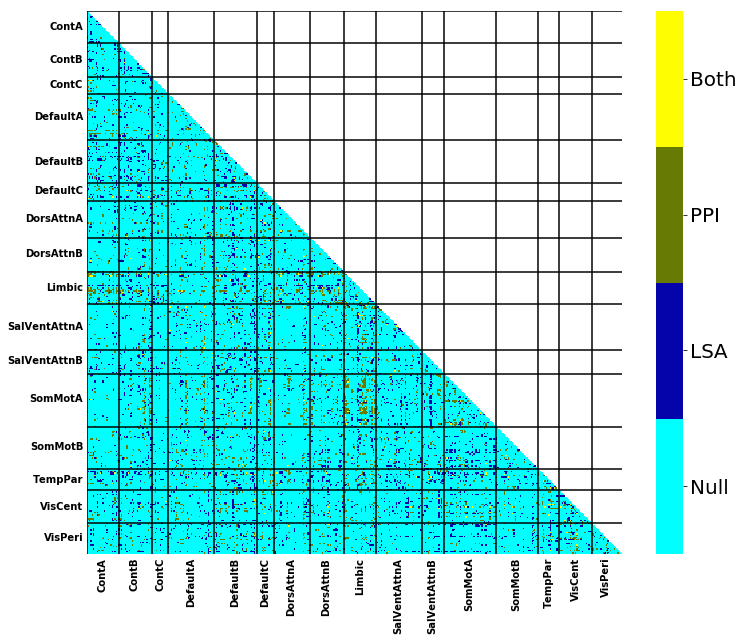

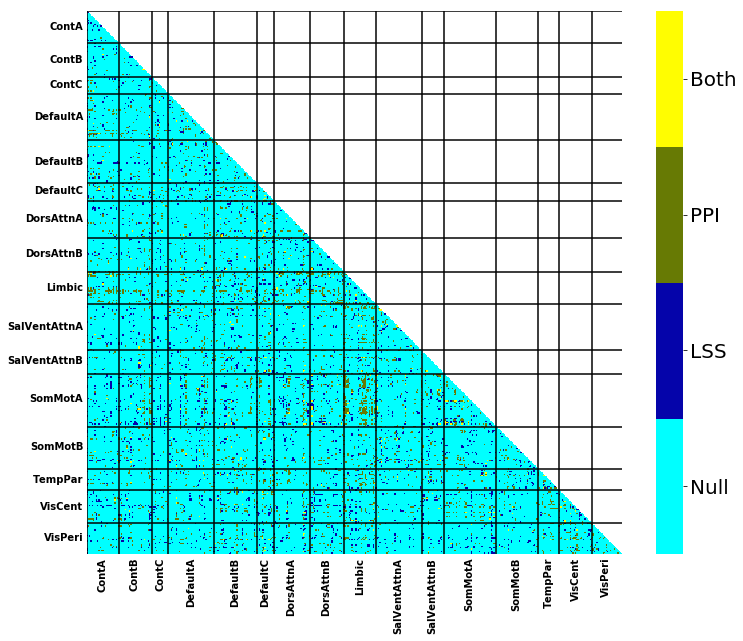

In [179]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    ts_sch_ppi_switchxrepeat, ts_sch_lss_switchxrepeat, ts_sch_lsa_switchxrepeat,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [180]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.30009307, 0.1683753 ],
       [0.30009307, 1.        , 0.39020495],
       [0.1683753 , 0.39020495, 1.        ]])

In [181]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

13
0.15810387589361571


## Schaefer Atlas: Switch - Repeat (Null Data)

Number of Positives lsa: 3904 / 79800
Number of Positives ppi: 4096 / 79800
Number of overlapping positives: 208 / 79800
Number of Positives lss: 4443 / 79800
Number of Positives ppi: 4096 / 79800
Number of overlapping positives: 228 / 79800


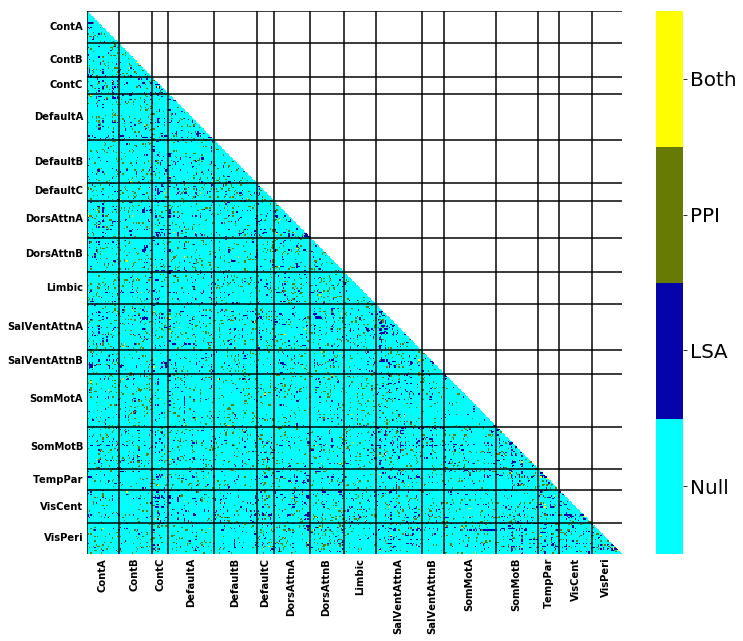

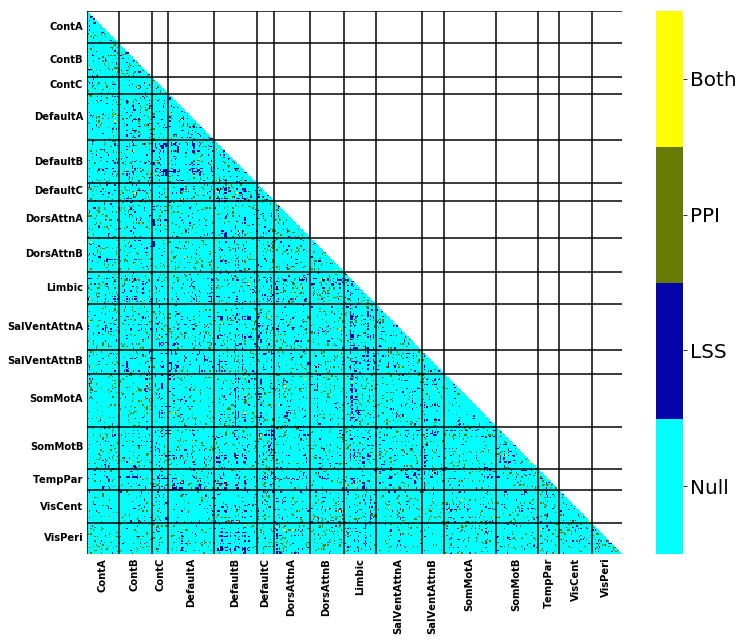

In [188]:
fig_lsa, fig_lss, ppi_model_df, lss_model_df, lsa_model_df, overlap_lsa_df, overlap_lss_df = nf.compare_ppi_lss_lsa_sig(
    fb_sch_ppi_switchxrepeat, fb_sch_lss_switchxrepeat, fb_sch_lsa_switchxrepeat,
    rois="schaefer", nthreads=N_THREADS, use_python=True)

In [189]:
np.corrcoef([lsa_model_df["estimate"], lss_model_df["estimate"], ppi_model_df["estimate"]])

array([[1.        , 0.28500166, 0.00722008],
       [0.28500166, 1.        , 0.01375872],
       [0.00722008, 0.01375872, 1.        ]])

In [190]:
bool_query = ppi_model_df['source'].isin(best_regions_orig) & ppi_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(ppi_model_df['p_value'][bool_query] < 0.05)
binom_pvalue = binom_test(num_sig, len(ppi_model_df['p_value'][bool_query]), prop=0.05, alternative='larger')
print(num_sig)
print(binom_pvalue)

14
0.09632047313777307
